# Introduction

This project builds upon Schneider et al. 2017 (S17). S17 looked at how to estimate parameters in a perfect model setup in a climate model setup. Here, I will extend this to the question of how to learn imperfect subgrid parameterization schemes.

**Study Layout**

1. Introduce Lorenz model with baseline statistics (this notebook)
1. Reproduce S17 EnKF results as a baseline
1. Learn subgrid parameterizations offline
    1. Deterministic polynomial (varying degree)
    1. Neural network
1. Try to estimate parameterizations in a climate setup using EnKF
5. ...

In [1]:
%load_ext autoreload
%autoreload 2

In [43]:
from L96 import *
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,7)
sns.set_style('dark')
sns.set_context('talk')

## The Lorenz 96 model

Our toy model will be the Lorenz 96 model with two levels. I am using the version of S17 but other ways of writing the equations exist.

The L96 model consists of a slow variable $X$ and a fast variable $Y$, which are coupled to each other. In the climate model analogy, the slow variable represents the resolved variables, such as grid-scale temperature, wind or pressure. $Y$ represents unresolved variables, such as cloud variables. The L96 model is cyclical and is described by the following coupled ODEs
$$
\frac{dX_k}{dt} = -X_{k-1}(X_{k-2}-X_{k+1})-X_k+F-hc\bar{Y}_k
$$
$$
\frac{dY_k}{dt} = c [ -b Y_{k-1}(Y_{k-2}-Y_{k+1})-Y_k + \frac{h}{J}X_k ]
$$
This model has four parameters, $\theta = \{F, h, c, b\}$ which are set to $\{10, 1, 10, 10\}$.

For simple tests I will also sometimes use the one layer model which is the first equation without the last term. It only has one prognostic variable and only one parameter, $\theta = F = 10$.

The important long term statistics to be matched are $\langle X \rangle, \langle \bar{Y} \rangle, \langle X^2 \rangle, \langle X\bar{Y} \rangle, \langle \overline{Y^2} \rangle$. For more information how these statistics relate to the parameters $\theta$, refer to S17, Section 4.1.

### Numerical implementation

The equations above are integrated using a fourth-order Runge-Kutta scheme with a time step $\Delta t = 0.001$. For a general, time-independent ODE $\frac{dX}{dt} = f(X)$, RK4 computes one step as

$$k_1 = \Delta t f(X_t)$$
$$k_2 = \Delta t f(X_t + k_1/2)$$
$$k_3 = \Delta t f(X_t + k_2/2)$$
$$k_4 = \Delta t f(X_t + k_32)$$
$$X_{t+\Delta t} = X_t + 1/6 (k_1 + 2k_2 + 2k_3 + k_4)$$

There are two ways to use RK4 for the coupled equation above: coupled and uncoupled. Given 

$$ \frac{dX_k}{dt} = f_X(X, Y) $$
$$ \frac{dY_k}{dt} = f_Y(X, Y) $$

the coupled version would be:

$$ k_{1,X} = \Delta t f_X(X_t, Y_t); k_{1,Y} = \Delta t f_Y(X_t, Y_t)$$
$$ k_{2,X} = \Delta t f_X(X_t + k_{1,X}/2, Y_t + k_{1,Y}/2); k_{2,Y} = \Delta t f_Y(X_t + k_{1,X}/2, Y_t + k_{1,Y}/2)$$
$$\cdots$$

While the uncoupled version would be:
$$k_{1,X} = \Delta t f_X(X_t, Y_t)$$
$$k_{2,X} = \Delta t f_X(X_t + k_{1,X}/2, Y_t)$$
$$\cdots$$
followed by
$$k_{1,Y} = \Delta t f_Y(X_t, Y_t)$$
$$k_{2,Y} = \Delta t f_Y(X_t, Y_t + k_{1,Y}/2)$$
$$\cdots$$

Since we later want to parameterize $\frac{dY_k}{dt}$, we will use the uncoupled version which differs only marginally from the coupled version in its statistics.

In [7]:
l96_coupled = L96TwoLevel(coupled=True)
l96_coupled.iterate(100)

In [8]:
l96_uncoupled = L96TwoLevel(coupled=False)  # This is the default
l96_uncoupled.iterate(100)

In [14]:
l96_coupled.history.X.mean(), \
l96_coupled.history.Y_mean.mean(), \
(l96_coupled.history.X**2).mean(), \
(l96_coupled.history.X*l96_coupled.history.Y_mean).mean(), \
l96_coupled.history.Y2_mean.mean()

(<xarray.DataArray 'X' ()>
 array(2.515894), <xarray.DataArray 'Y_mean' ()>
 array(0.098971), <xarray.DataArray 'X' ()>
 array(18.749238), <xarray.DataArray ()>
 array(0.63133), <xarray.DataArray 'Y2_mean' ()>
 array(0.063123))

In [13]:
l96_uncoupled.history.X.mean(), \
l96_uncoupled.history.Y_mean.mean(), \
(l96_uncoupled.history.X**2).mean(), \
(l96_uncoupled.history.X*l96_uncoupled.history.Y_mean).mean(), \
l96_uncoupled.history.Y2_mean.mean()

(<xarray.DataArray 'X' ()>
 array(2.58526), <xarray.DataArray 'Y_mean' ()>
 array(0.100686), <xarray.DataArray 'X' ()>
 array(19.30491), <xarray.DataArray ()>
 array(0.644862), <xarray.DataArray 'Y2_mean' ()>
 array(0.064552))

### Long-term statistics

In [ ]:
l96 = L96TwoLevel(noYhist=True)
l96.iterate(20_000)

### The parameterization task

After reproducing S17, we will primarily be interested in parameterizing the $Y$ tendency. The equation then looks as follows:
$$
\frac{dX_k}{dt} = -X_{k-1}(X_{k-2}-X_{k+1})-X_k+F+B_k
$$
In the real equations $B_k=-hc\bar{Y}_k$. The task is then to find a parameterization $B_k=P(X_k)$. This assumes locality in space and time. Again, there are two ways of integrating the parameterized equation in time. The first is to use $B_k$ inside the RK4 scheme. The other is to do the RK4 step without the last term in above equation and then updating it afterwards with $X_{t+1} = X_t + \Delta t B_t$. The latter version is more akin to what is done in climate models where parameterization updates are usually applied to the state vector outside of the dynamical core. Here we will use the first version and hope that this does not make too much of a difference.

In [16]:
l96 = l96_uncoupled

In [17]:
h = l96.history

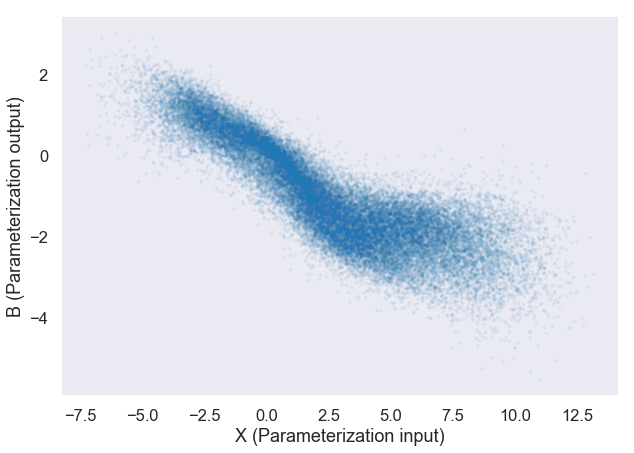

In [44]:
plt.scatter(np.ravel(h.X), np.ravel(h.B), s=5, alpha=0.05);
plt.xlabel('X (Parameterization input)')
plt.ylabel('B (Parameterization output)');

This figure shows the parameterization task. The L96 model is chaotic, which means that there is no deterministic relationship between $X$ and $B$. Several authors have developed stochastic parameterizations for $B$. For now, we will stick to deterministic parameterizations.

### How long do statistics need to be? How soon do biases show up?

### How does changing parameters affect the model behavior